In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import img_as_float
from skimage import color

In [2]:
path_to_training_retinal_ims = 'data/training/images/'
path_to_training_retinal_masks = 'data/training/masks/'
path_to_training_retinal_vessels = 'data/training/vessels/'
path_to_training_arteries = 'data/training/arteries/'
path_to_training_veins = 'data/training/veins/'

In [3]:
retinal_im_list = os.listdir(path_to_training_retinal_ims)

You probably want to put this functions inside a separate module that you can import, something called for instance ``extract_features_from_retinal_image``. Note that this functions accept a ``retinal_image`` object.

In [4]:
def compute_saturation(retinal_image):
    '''
    This function expects a retinal_image object
    1) retinal image 
    2) Field Of View mask 
    3) binary vessel map
    4) binary artery map
    5) binary vein map
    You may want to use (part of) them, or not
    '''
    return color.rgb2hsv(retinal_image.image)[:,:,1]

def compute_red_intensity(retinal_image):
    '''
    This function expects a retinal_image object.
    '''
    return retinal_image.image[:,:,0]

Note that, while these were trivial-to-compute features, you may want to compute more complex features, like the local mean intensity around each pixel. In that case, you may not want to compute the feature on every pixel of the image, but rather only on top of vessel pixels, to save time. You do not care about feature values outside the vessel map, since you only want to classify vessel pixels. There is where it could be useful to use the binary vessel map.

This is the defintion of a ``retina_image`` object. It holds the relevant data (image, binary mask with Field of View, binary mask with vessel map, binary mask with artery map, binary mask with vein map. These are loaded at instanatiation time by the constructor, thanks to the image name, which is passed as a parameter. The relative path to the data is a global variable defined above.

In [5]:
class retinal_image:   
    def __init__(self, name, train_or_test):
        self.name = name
        if train_or_test == 'train':
            path_im = path_to_training_retinal_ims
            path_mask = path_to_training_retinal_masks
            path_vessels = path_to_training_retinal_vessels
            path_arteries = path_to_training_arteries
            path_veins = path_to_training_veins
        elif train_or_test == 'test':
            path_im = path_to_training_retinal_ims
            path_mask = path_to_training_retinal_masks
            path_vessels = path_to_training_retinal_vessels
            path_arteries = path_to_training_arteries
            path_veins = path_to_training_veins
        else:
            print('Invalid mode')
            
        self.image = img_as_float(io.imread(path_im+name))
        self.mask = io.imread(path_mask+name[:-4]+'_mask.gif', dtype=bool)
        self.vessels = io.imread(path_vessels+name, dtype=bool) #[:-4]+'.png'
        self.arteries = io.imread(path_arteries+name, dtype=bool) #[:-4]+'.png'
        self.veins = io.imread(path_veins+name, dtype=bool) #[:-4]+'.png'
        
        # AVAILABLE FEATURES: These are place-holders for features that you may want to compute out of each image
        self.saturation = None
        self.red_intensity = None
        
    # The retinal_image object knows how to compute these features. 
    # It does that by calling to the functions defined in the previous cells    
    def load_saturation(self):
        # this calls an external function. If the attribute has not been initialized above, this will crash.
        self.saturation = compute_saturation(self)
    
    def load_red_intensity(self):
        self.red_intensity = compute_red_intensity(self)       

Let us instantiate a `retinal_image` object:

In [6]:
image = retinal_image(retinal_im_list[0], 'train')

In [7]:
print(image.saturation)

None


**A note of caution:** If some of your features are computationally really expensive to compute, you may want to compute them just once, save them to disk, and write a different load function, like this:

In [8]:
def load_my_fancy_feature(self):
    # my_fancy_eature has been already computed, and stored with the same name as the image 
    # plus an underscore plus the name of the feature
    precomputed_feature_name = self.name[:-4] + '_my_fancy_feature' + '.npy'
    self.my_fancy_feature = np.load(precomputed_feature_name)

See [here](https://stackoverflow.com/a/37996966/3208255) for a simple example on how to load and save numpy arrays to memory.

At the moment, this object only holds the data, no feature has been computed:

In [9]:
print(image.saturation)

None


We can compute the features by calling to the internal methods of the `retinal_image` object.

In [10]:
image.load_saturation()
image.load_red_intensity()

Now, these are images and we can visualize them:

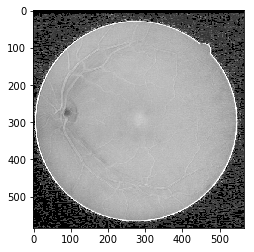

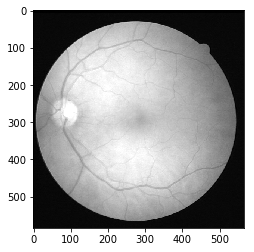

In [24]:
plt.imshow(image.saturation, cmap='gray')
plt.show()
plt.imshow(image.red_intensity, cmap='gray')
plt.show()

You want now to loop on the training set, load the appropriate features, and build a training set. Note that we consider veins to be the positive class.

I highly recommend you to fully understand what is going on in the cell below. Try to trace the code starting with i=0, seeing what happens, and then the same for i=1, observe how the `X` matrix is sequentially filled with different values, and the same for the groundtruth vector `y`

In [12]:
nr_retinal_ims = len(retinal_im_list)
nr_ims = len(retinal_im_list)

nr_features = 2 # red intensity and saturation

# the number of samples depends on the number of vessel pixels we select
nr_artery_samples_per_image = 30
nr_vein_samples_per_image = 30
# nr of pixel samples is the sum of these
nr_samples_per_image =  nr_artery_samples_per_image + nr_vein_samples_per_image
# total number of examples is number of samples per image multiplied by nr of images
nr_examples = nr_ims *nr_samples_per_image

# pre-allocate training examples matrix
X = np.zeros([nr_examples, nr_features])
# pre-allocate ground-truth vector
y = np.zeros([nr_examples,])

for i in range(nr_ims):
    im_name = retinal_im_list[i]
    image = retinal_image(im_name, 'train')

    # Load features
    image.load_red_intensity()
    image.load_saturation()

    # extract samples from arteries
    arteries_samples_red_intensity = image.red_intensity[image.arteries == True]
    # extract samples from veins
    veins_samples_red_intensity = image.red_intensity[image.veins == True]

    # extract samples from arteries
    arteries_samples_saturation = image.saturation[image.arteries == True]
    # extract samples from veins
    veins_samples_saturation = image.saturation[image.veins == True]


    # randomly choose which artery examples to use, 1st column for red, 2nd for sat
    random_sample = np.random.randint(len(arteries_samples_red_intensity), size=nr_artery_samples_per_image)

    # first 20 examples are arteries
    X[i*nr_samples_per_image:i*nr_samples_per_image+nr_artery_samples_per_image,0] = arteries_samples_red_intensity[random_sample]
    X[i*nr_samples_per_image:i*nr_samples_per_image+nr_artery_samples_per_image,1] = arteries_samples_saturation[random_sample]
    
    # arteries are the negative class
    y[i*nr_samples_per_image:i*nr_samples_per_image+nr_artery_samples_per_image] = np.zeros(nr_artery_samples_per_image,)  
    
    # randomly choose which vein examples to use                                          
    random_sample = np.random.randint(len(veins_samples_red_intensity), size=nr_vein_samples_per_image)
    
    # second twenty examples are veins
    X[i*nr_samples_per_image+nr_vein_samples_per_image:i*nr_samples_per_image+nr_samples_per_image,0] = veins_samples_red_intensity[random_sample]
    X[i*nr_samples_per_image+nr_vein_samples_per_image:i*nr_samples_per_image+nr_samples_per_image,1] = veins_samples_saturation[random_sample]
    
    # veins are the positive class
    y[i*nr_samples_per_image+nr_vein_samples_per_image:i*nr_samples_per_image+nr_samples_per_image] = np.ones(nr_vein_samples_per_image,)  
    
    print(i+1, '/', nr_ims)

1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


Now `X` is our training matrix, holding `nr_examples x nr_features` values:

In [13]:
X.shape

(1200, 2)

Let us scale the features:

In [14]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

We split the training set into a training and a validation set:

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

Now we can train, for example, an SVM on the training set, and compute its performance on the validation set:

In [16]:
from sklearn import svm
gamma = 1 # SVM RBF radius
svc_kernel = svm.SVC(kernel='rbf', gamma=gamma, decision_function_shape='ovr', probability=True)
svc_kernel.fit(X_train, y_train)
svc_kernel.score(X_val, y_val)

0.52020202020202022

Not really good. Quite bad, in fact. Your goal is to improve this result by designing better (more discriminative) features, and investigating if a better classifier (or this one, by cross-validated to find out a better hyperparameter configuration) can improve performance.

Below you can find some code to visualize the results and do some pretty plots -- notice these plots will only be possible with two features (two-dimensional feature space), but it gives you an idea of what is going on above. It also gives you an idea of how bad were the features I selected in the first place (red intensity and saturation), since you will see that it hardly separates the data.

In [17]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [18]:
def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.65, **params)


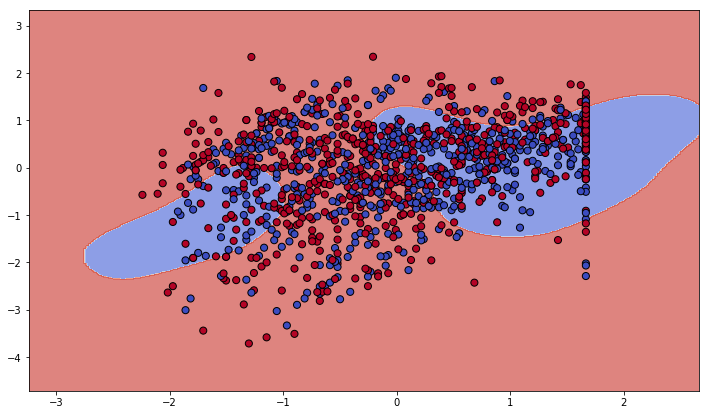

In [19]:
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
plt.figure(figsize=(12,7))
plot_contours(svc_kernel, xx, yy)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
plt.show()

# Computing the Results you need to submit
Once you are happy with the result of your classifier, you need to apply it to build predictions on the test set, for which only me has the result. I expect from you, out of the test set, a set of images holding, at each vessel pixel, the predictions your model makes. This means that on every vessel pixel your result should have a single number in between 0 and 1. If the number is 1, your classifier is completely sure that pixel is a vein, and viceversa.

In [21]:
path_to_test_ims = 'data/test/images/'
path_to_test_vessels = 'data/test/vessels/'

In [22]:
test_im_list = os.listdir(path_to_test_ims)

**Note: I will update this part of the code as soon as I have the time.**

After receiving your submission, I will compare your predictions with the groundtruth, and send you back an ROC curve and some numerical performance results to include in your final report.